In [10]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import json
import pickle
import colorsys

In [31]:
# Adds colors for linkages by blending the leave colors together, recursively
# if t is 1, color2 is returned, if it is 0, color1 is
def blend_colors(color1, color2, weight):
    # Convert RGB colors to HSV
    hsv1 = colorsys.rgb_to_hsv(*color1)
    hsv2 = colorsys.rgb_to_hsv(*color2)

    # Blend the colors based on the weight
    blended_hsv = (
        (1 - weight) * hsv1[0] + weight * hsv2[0],    # Weighted average of the hues
        (1 - weight) * hsv1[1] + weight * hsv2[1],    # Weighted average of the saturations
        (1 - weight) * hsv1[2] + weight * hsv2[2]     # Weighted average of the values/brightness
    )

    # Convert the blended color back to RGB
    blended_rgb = colorsys.hsv_to_rgb(*blended_hsv)

    return blended_rgb

# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
#  Creates value of links, such as color, by blending together leaf values
def create_link_values(linkage_matrix, leaf_values,
                      merge_function = lambda cluster1_val, cluster2_val, weight: cluster1_val * (1 - weight) + cluster2_val * weight,
                      weight_function = lambda cluster1_size, cluster2_size: cluster2_size / (cluster1_size + cluster2_size)):
    # Merge function takes val1, val2, and a weight (0-1, 0 preferences val1, 1 preferences val2) and returns a merged value

    num_leaves = len(leaf_values)
    
    new_values = leaf_values.copy()
    for row in linkage_matrix:
        cluster1_id = int(row[0])
        cluster2_id = int(row[1])

        if cluster1_id < num_leaves: # it is a sample/leaaf
            cluster1_size = 1
        else:
            cluster1_size = linkage_matrix[num_leaves - cluster1_id][-1]
        
        if cluster2_id < num_leaves: # it is a sample/leaf
            cluster2_size = 1
        else:
            cluster2_size = linkage_matrix[num_leaves - cluster2_id][-1]

        # If a cluster is huge and is merged with a leaf, the weight should preference the cluster
        # Can try different weighting here
        weight = weight_function(cluster1_size, cluster2_size)

        merged_cluster_value = np.array([merge_function(new_values[cluster1_id], new_values[cluster2_id], weight)])

        new_values = np.concatenate((new_values, merged_cluster_value), axis=0)

    return new_values

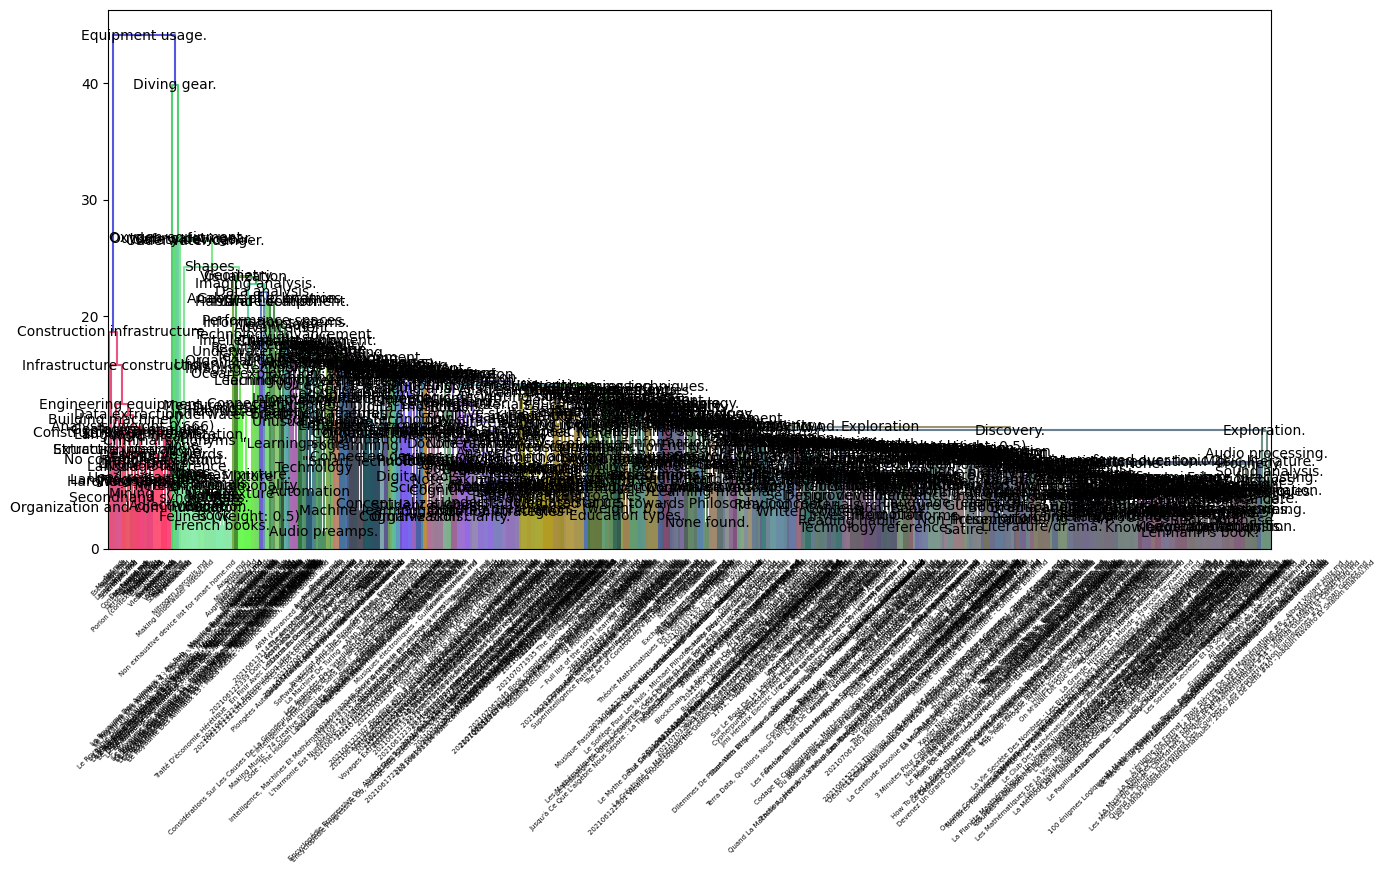

In [92]:
# loads in complete_clusters.pkl, all_values.pkl, pca5_normalized.json, and Z.pkl
leaf_link_labels = np.array(pickle.load(open('all_values.pkl', 'rb')))[:,5]
embeddings_pca5_normalized = json.load(open('pca5_normalized.json', 'r'))
linkage_matrix = np.array(pickle.load(open('Z.pkl', 'rb')))

num_leaves = len(leaf_link_labels) - len(linkage_matrix)
leaf_labels = leaf_link_labels[:num_leaves]

leaf_colors = []
for leaf_label in leaf_labels:
    if leaf_label not in embeddings_pca5_normalized:
        print(leaf_label + " NOT IN PCA5_NORMALIZED")
    leaf_colors.append(embeddings_pca5_normalized[leaf_label][2:5])
leaf_colors = np.array(leaf_colors) / 256.0

leaf_link_colors = create_link_values(linkage_matrix, leaf_colors, merge_function=blend_colors)
leaf_link_colors = [mcolors.to_hex(color) for color in leaf_link_colors]

# cluster1, cluster2, distance, cluster size, label1, label2, new_label, color 
master_link = []
for i in range(num_leaves):
    master_link.append([i, i, 0, 1, leaf_link_labels[i], leaf_link_labels[i], leaf_link_labels[i], leaf_link_colors[i]])

for i, row in zip(range(len(linkage_matrix)), linkage_matrix):
    label1 = leaf_link_labels[int(row[0])]
    label2 = leaf_link_labels[int(row[1])]
    new_label = leaf_link_labels[num_leaves + i]

    master_link.append([*row, label1, label2, new_label, leaf_link_colors[num_leaves + i]])


plt.figure(figsize=(15, 7))

ddata = dendrogram(linkage_matrix, leaf_rotation=45, labels=leaf_labels, link_color_func=lambda link_id: leaf_link_colors[link_id])

# Creates a dictionary mapping distance to linkage matrix row
# If distances are not unique, the dendrogram will not be correct, prints warning
if len(np.unique(linkage_matrix[:,2])) != len(linkage_matrix[:,2]):
    print("WARNING: Distances are not unique, dendrogram will not be correct")
    linkage_matrix[:,2] += np.random.normal(0, 0.0001, linkage_matrix.shape[0]) # LOL
    master_link[num_leaves:,2] = linkage_matrix[:,2]

link_distance_to_masterlink_row = {}
for i in range(len(linkage_matrix)):
    link_distance_to_masterlink_row[linkage_matrix[i,2]] = i + num_leaves

master_link_rows_in_dendrogram_order = np.array([link_distance_to_masterlink_row[distance] for distance in np.array(ddata['dcoord'])[:,2]])

for i in range(len(ddata['dcoord'])):
    icoord = ddata['icoord'][i]
    dcoord = ddata['dcoord'][i]
    label = master_link[master_link_rows_in_dendrogram_order[i]][6]

    mid_x = 0.5 * sum(icoord[1:3])
    mid_y = dcoord[1]

    plt.text(mid_x, mid_y, label, va='center', ha='center', size=10)



In [39]:
'''
To order the link labels of the dendrogram, we must correlate the order of the coords in the dendrogram with 
the order of the linkage matrix.
Index 1 and 2 of dcoord represents the distance between the merging, this can be used to index into the linkage
matrix, however, this assumes the distances are unique. If there is a duplicate distance (meaning a link with 
the same height at the top) it SEEMS that the coords are ordered left to right, so there is probably a way to
use the leaf ordering to then get the proper rows in the linkage matrix. However, this is not implemented yet. 

In the meantime, if there are overlapping distances, we can just add a small amount of noise to the distances.
'''

In [34]:
num_leaves = all_values.shape[0] - complete_clusters.shape[0]


link_labels = complete_clusters[:, 5] # NOT IN ORDER OF DENDROGRAM LINKS

leaf_names = all_values[:num_leaves, 5]

linkage_matrix = Z


/Users/aidanbx/miniconda/envs/cv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/aidanbx/miniconda/envs/cv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128140 (\N{LOVE LETTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


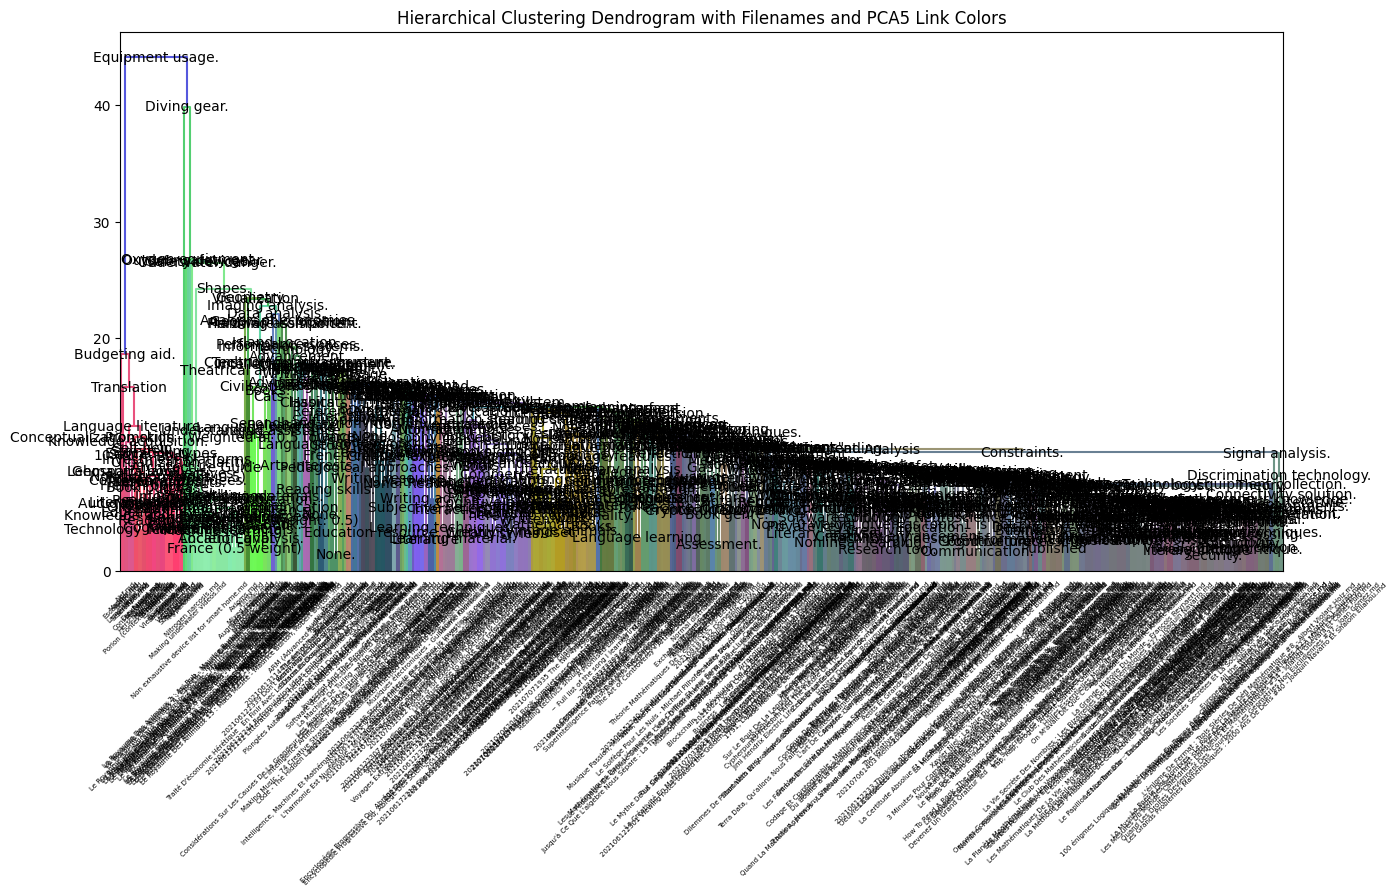

In [35]:
plt.figure(figsize=(15, 7))


link_leaf_colors = create_link_values(linkage_matrix, colors, merge_function=blend_colors)
link_leaf_colors = [mcolors.to_hex(color) for color in link_leaf_colors]

# Plot the dendrogram with custom labels and link colors
ddata = dendrogram(linkage_matrix, leaf_rotation=45, labels=leaf_names, link_color_func=lambda link_id: link_leaf_colors[link_id])



for icoord, dcoord, label in zip(ddata['icoord'], ddata['dcoord'], link_labels):
    x = 0.5 * sum(icoord[1:3])
    y = dcoord[1]
    plt.text(x, y, label, va='center', ha='center', size=10)


plt.title('Hierarchical Clustering Dendrogram with Filenames and PCA5 Link Colors')
plt.show()